# Projet MOGPL: la balade du robot

### Sportich Benjamin, de Bézenac Emmanuel

In [1]:
%matplotlib nbagg
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import numpy as np
import time
from random import choice

/home/emmanuel/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## LECTURE ET ECRITURE DE FICHIER

In [2]:
def read_entry_file(filename):
    with open(filename) as f:
        k=0
        inst_size=245 #arbitrary number
        inst_list=[]
        for line in f:
            if(k==0%inst_size):
                M=int(line.split()[0]) # lecture de la premiere ligne
                N=int(line.split()[1]) # lecture de la premiere ligne
                inst_size=M+2
                k+=1
                array = [] 
            elif(k<=(M%inst_size)): # lecture du bloc                
                array.append(np.array([int(x) for x in line.split()]))
                k+=1
            
            elif(k==M%inst_size+1): #lecture du début, de la fin, ainsi que de la direction
                iStart,jStart,iEnd,jEnd=[int(line.split()[i]) for i in range(4)]
                startDir=line.split()[4]
                if(startDir=='nord'):
                    startDir=1
                if(startDir=='est'):
                    startDir=2
                if(startDir=='sud'):
                    startDir=3
                if(startDir=='ouest'):
                    startDir=4 
                k+=1
            else:
                inst_list.append((M,N,np.array(array),(iStart,jStart,startDir),(iEnd,jEnd,1)))
                k=0
    return inst_list

#Ecriture de fichier d'entree
#def write_entry_file(filename,A,startPos,endPos,startDir):
def write_entry_file(filename,mod,A,startPos,endPos,startDir):
    f=open(filename,mod)
    f.write(str(A.shape[0])+' '+str(A.shape[1])+'\n')
    for i in A:
        f.write(' '.join(str(int(e)) for e in i))
        f.write('\n')
    if(startDir==1):
        d='nord'
    if(startDir==2):
        d='est'
    if(startDir==3):
        d='sud'
    if(startDir==4):
        d='ouest'
    f.write(str(startPos[0])+' '+str(startPos[1])+' '+str(endPos[0])+' '+str(endPos[1])+' '+d+'\n')
    f.write('0 0\n')
    f.close()

#Ecriture de fichier de resultat
#filename : nom du fichier 
#mod : type d'écriture w creation de nouveau fichier a ajout à la fin du fichier déja créé
#result : 
def write_result_file(filename,mod,result):
    f=open(filename,mod)
    f.write(str(result[0])+' '+' '.join(e for e in result[1])+'\n')
    f.close()

## GENERATION ALEATOIRE D'INSTANCES

In [3]:
#M : nombre de lignes
#N : nombre de colonnes
#nb_obstacles : nombre d'obstacles
#Genere un tableau d'obstacles A à partir des paramètres en entrée
def gen_rand_instance(M,N,nb_obstacles):
    A=np.zeros((M,N),dtype=int)
    obstacles=[]
    if(nb_obstacles<=M*N-4):
        #Generation d'obstacles
        for i in range(nb_obstacles):
            obstacle=(int(np.random.rand()*M),int(np.random.rand()*N))
            while(obstacle in obstacles): #Obstacle déjà créé
                obstacle=(int(np.random.rand()*M),int(np.random.rand()*N))
            A[obstacle]=1
            obstacles.append(obstacle)        
    else:
        print 'Erreur, trop d\'obstacles.'
        
    return A

#Renvoie les positions de départ et d'arrivée à PARTIR D'UN GRAPHE DEJA CREE (!!)
def gen_rand_positions(G):
    startPos=choice(G.nodes())
    endPos=choice(G.nodes())
    return startPos,endPos


## CREATION & GESTION DU GRAPHE

###  Teste si le point $(i,j) \in O$

In [4]:
def is_obstacle(i,j,A): #Teste si le point (i,j) appartient a O (O=X\P)
    M=A.shape[0]
    N=A.shape[1]
    #Cas Limites
    if(i==0): #Premiere ligne
        if(j==0): #Premiere case
            return A[0][0]
        if(j==N): #Derniere case
            return A[0][N-1]
        if(j>0 and j<N): #Cases restantes
            return A[0][j] or A[0][j-1]       
    if(i==M): #Dernière ligne
        if(j==0): #Premiere case
            return A[M-1][0]
        if(j==N): #Derniere case
            return A[M-1][N-1]
        if(j>0 and j<N): #Cases restantes
            return A[M-1][j-1] or A[M-1][j] 
    if(j==0): #Premiere colonne 
        if(i>0 and i<M): #Cases restantes
            return A[i][0] or A[i-1][0]       
    if(j==N): #Derniere colonne 
        if(i>0 and i<M): #Cases restantes
            return A[i-1][N-1] or A[i][N-1] 
    #Cas General
    if( i>=1 and j>=1 and i<M and j<N and A[i-1][j-1]==0 and A[i][j-1]==0 and A[i-1][j]==0 ):
        return A[i][j]
    return 1

### Génère le graphe en fonction du tableau d'obstacles

In [5]:
def gen_graph(A):
    M=A.shape[0]
    N=A.shape[1]
    G=nx.DiGraph()
    for i in range(M+1):
        for j in range(N+1):
            if(is_obstacle(i,j,A)==False): # le point (i,j) n'appartient pas a O, il appartient donc a P.            
                #Creation des noeuds - un par direction = 4 par position                
                G.add_node((i,j,1),direct='nord')
                G.add_node((i,j,2),direct='est')
                G.add_node((i,j,3),direct='sud')
                G.add_node((i,j,4),direct='ouest')

                #Creation des arcs
                #Changement des directions               
                G.add_edge((i,j,1),(i,j,2),action='D')
                G.add_edge((i,j,1),(i,j,4),action='G')
                G.add_edge((i,j,2),(i,j,3),action='D')
                G.add_edge((i,j,3),(i,j,4),action='D')

                G.add_edge((i,j,2),(i,j,1),action='G')
                G.add_edge((i,j,4),(i,j,1),action='D')
                G.add_edge((i,j,3),(i,j,2),action='G')
                G.add_edge((i,j,4),(i,j,3),action='G')

                #Deplacement
                #Nord/Haut
                for k in [1,2,3]:
                    if(is_obstacle(i-k,j,A)==False): #(i,j) et (i-k,j) appartiennent a P, on peut donc creer l'arc
                        G.add_edge((i,j,1),(i-k,j,1),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                #Est/Droite
                for k in [1,2,3]:
                    if(is_obstacle(i,j+k,A)==False):
                        G.add_edge((i,j,2),(i,j+k,2),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en j+k on ne creer pas d'arc en j+k+1
                
                #Sud/Bas
                for k in [1,2,3]:
                    if(is_obstacle(i+k,j,A)==False):
                        G.add_edge((i,j,3),(i+k,j,3),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i+k on ne creer pas d'arc en i-k+1
                
                #Ouest/Gauche
                for k in [1,2,3]:
                    if(is_obstacle(i,j-k,A)==False):
                        G.add_edge((i,j,4),(i,j-k,4),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en j-k on ne creer pas d'arc en j-k-1
                        
    return G

Exemple:

In [6]:
nombre_inst=3
filename='test_entree.txt'
with open(filename,'w'): #on vide le fichier
    pass

for i in range(nombre_inst): #on remplis au fur et a mesure le fichier 
    A=gen_rand_instance(5+i,5+i,6+i)
    Gr=gen_graph(A)
    st,en=gen_rand_positions(Gr)
    write_entry_file(filename,'a',A,st[:2],en[:2],st[2])

l=read_entry_file(filename) #on lis le fichier
# le resultat est un tuple d'instances 
# une instance est definie comme: (M,N,A,(iStart,jStart,startDir),(iEnd,jEnd,1)
print l

[(5, 5, array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]]), (5, 2, 4), (3, 4, 1)), (6, 6, array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1]]), (0, 0, 1), (3, 5, 1)), (7, 7, array([[0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0]]), (6, 1, 4), (6, 0, 1))]


## MEILLEUR CHEMIN

In [7]:
def BFS(start,end,G):
    dist={}
    for i in G.nodes():
        dist[i]=[np.inf,None] #dist: [distance a start, predecesseur]
    dist[start][0]=0 
    q=[start] #on mets le premier element dans la queue q
    while(q):# tant que la queue n'est pas vide
        
        u=q.pop(0) #on retire le prochain element de la queue q pour l'assigner a u
        
        for v in G.neighbors(u): #on explore tout les voisins de u
            
            if(np.isinf(dist[v][0])): #si le voisin v de u n'a pas encore ete exploré
                dist[v][0]=dist[u][0]+1
                dist[v][1]=u # le predecesseur de v est u
                q.append(v) #on rajoute v a la queue
                if(v[:2]==end[:2]): #on s'arrete lorsqu'on voit la fin
                    return dist
    return dist


def gen_shortest_path(start,end,G):
    #Backtracking: on retrouve le chemin minimal a partir d'un des 4 sommets de la fin
    dist=BFS(start,end,G) #resultat du BFS
    path=[] #stocke l'action associé aux arcs parcourus
    path_edges=[] #stocke le nom des arcs parcourus
    i=end[0]
    j=end[1]
    dist_end=[dist[(i,j,1)][0],dist[(i,j,2)][0],dist[(i,j,3)][0],dist[(i,j,4)][0]]
    k=np.argmin(dist_end)+1 #renvoie la direction de la derniere etape
    if(dist_end[k-1]==np.inf): #si on n'a pas parcouru la position end
        return -1,[],[]
    prec=(i,j,k)
    while(prec!=start):
        temp=prec
        prec=dist[prec][1]
        path_edges.append([prec,temp])
        path.append(G[prec][temp]['action'])
    return len(path),path[::-1],path_edges[::-1] 
    #on renvoie le cout du chemin, ainsi les listes dans l'ordre inverse

## AFFICHAGE DU GRAPHE

In [8]:
from matplotlib.patches import FancyArrowPatch, Circle

def fixed_pos(G): #Assigne des positions aux noeuds du graphe
    fixed_pos={}
    for n in G.nodes():
        if(n[2]==1):
            fixed_pos[n]=(int(n[1])*4+1,int(n[0])*4)
        if(n[2]==2):
            fixed_pos[n]=(int(n[1])*4+2,int(n[0])*4+1)
        if(n[2]==3):
            fixed_pos[n]=(int(n[1])*4+1,int(n[0])*4+2)
        if(n[2]==4):
            fixed_pos[n]=(int(n[1])*4,int(n[0])*4+1)        
    return fixed_pos


def draw_graph(G,pos,ax,sg=None): #Genere l'affichage du graphe
    G_new=G.copy()
    for n in G_new:
        c=Circle(pos[n],radius=0.15,alpha=0.5)
        ax.add_patch(c)
        G_new.node[n]['patch']=c
        x,y=pos[n]
    seen={}
    for (u,v,d) in G_new.edges(data=True):
        n1=G_new.node[u]['patch']
        n2=G_new.node[v]['patch']
        rad=0.2
        if (u,v) in seen:
            rad=seen.get((u,v))
            rad=(rad+np.sign(rad)*0.1)*-1
        alpha=0.5
        color='k'
        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
                            connectionstyle='arc3,rad=%s'%rad,
                            mutation_scale=10.0,
                            lw=2,
                            alpha=alpha,
                            color=color)
        seen[(u,v)]=rad
        ax.add_patch(e)
    return e

def show_graph(G,figsize=(7,7)): # affiche le graphe
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(111)
    ax.invert_yaxis()
    draw_graph(G,fixed_pos(G),ax)
    ax.autoscale()
    plt.axis('equal')
    plt.axis('off')
    plt.savefig('graph2.png')
    plt.show()
    #nx.draw_networkx(G,fixed_pos,ax=axe,arrows=True,node_size=400,font_size=10)
    #nx.draw(G,fixed_pos(G),ax=axe)

##  AFFICHAGE SOLUTION

In [9]:
from matplotlib.table import Table
import matplotlib.lines as lines
from matplotlib.patches import Circle, Arrow,FancyArrowPatch

def show_interface(result,A,startPos,endPos,figsize=(8,8)):
    colors=['white','grey']
    fig=plt.figure(figsize=figsize)
    ax=plt.subplot(111)    
    ax.set_ylim([0,A.shape[0]])
    ax.set_xlim([0,A.shape[1]])
    ax.set_axis_off()
    tb = Table(ax, bbox=[0,0,1,1])
    nrows, ncols = A.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    # Add cells
    for (i,j),val in np.ndenumerate(A):
        color=colors[val]
        tb.add_cell(i, j, width, height,loc='center', facecolor=color)
    # Row Labels...
    for i in range(A.shape[0]):
        tb.add_cell(i, -1, width, height, text=i, loc='right', 
                    edgecolor='none', facecolor='none')
    # Column Labels
    for j in range(A.shape[1]):
        tb.add_cell(-1, j, width, height/2, text=j, loc='center', 
                           edgecolor='none', facecolor='none')
    ax.add_table(tb)
    
    #Ajout Chemin
    for i,j in result[2]:
        ax.add_line(lines.Line2D((i[1],j[1]),(i[0],j[0]),linewidth=3,zorder=1))
    
    #Ajout Depart
    start=startPos[:2][::-1]
    start_circle=Circle(start,radius=0.2,alpha=0.8, color='g',zorder=2,label='Position de Depart')
    ax.add_patch(start_circle)
    
    #Ajout Direction de Depart
    start_dir=startPos[2]
    start_posA=start
    if(start_dir==1):        
        start_posB=(start_posA[0],start_posA[1]-1)
    if(start_dir==2):
        start_posB=(start_posA[0]+1,start_posA[1])
    if(start_dir==3):
        start_posB=(start_posA[0],start_posA[1]+1)
    if(start_dir==4):
        start_posB=(start_posA[0]-1,start_posA[1])    
    arrow=FancyArrowPatch(start_posA,start_posB,arrowstyle='->',color='m',mutation_scale=15.0,lw=2,zorder=3,label='Sens de Depart')
    ax.add_patch(arrow)

    #Ajout Arrivee
    end=endPos[:2][::-1]
    end_circle=Circle(end,radius=0.2,alpha=0.9, color='r',zorder=2,label='Position d\'arrivee')
    ax.add_patch(end_circle)
    
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

## INTERFACE 

<IPython.core.display.Javascript object>


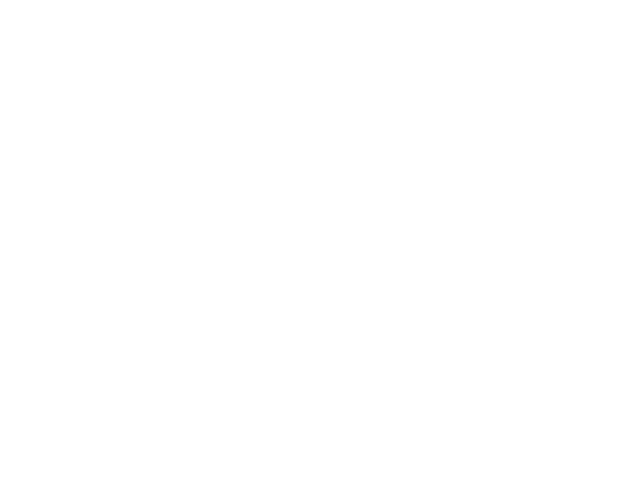

<IPython.core.display.Javascript object>


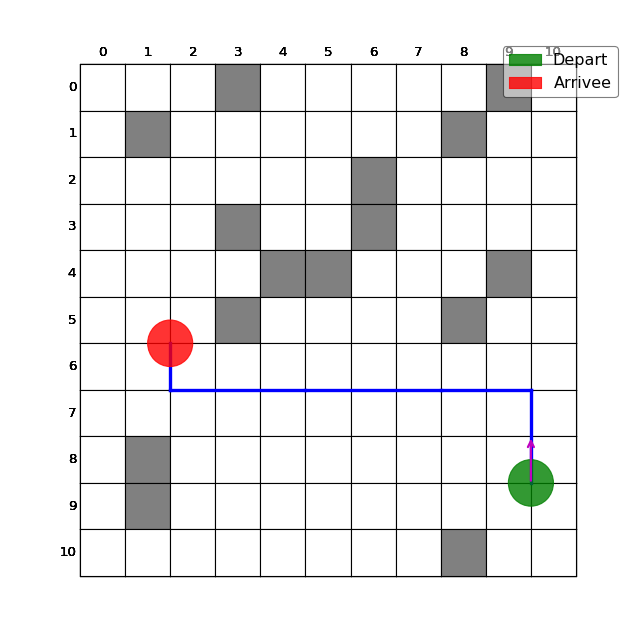

In [10]:
from matplotlib.table import Table
import matplotlib.lines as lines
from matplotlib.patches import Circle, Arrow,FancyArrowPatch
from ipywidgets import Button,IntSlider,Latex,HBox
from IPython.display import display
import time

class Interface():
    def __init__(self,figsize=(6,6)):
        self.figsize=figsize
        self.size_slider=IntSlider(description='Grid Size',min=4,max=50)
        display(self.size_slider)

        self.nb_ob_slider=IntSlider(description='Obstacles',min=0,max=7)
        display(self.nb_ob_slider)

        self.gen_inst_button=Button(description='Generate Instance',margin=10)
        self.gen_pos_button=Button(description='Generate Start/End Positions',margin=10)
        self.gen_path_button=Button(description='Generate Path',margin=10)
        self.inst_but_container=HBox(children=[self.gen_inst_button,self.gen_pos_button,self.gen_path_button])
        self.inst_but_container.width = '100%'
        display(self.inst_but_container)

        self.show_path_button=Latex(value='Path: Value:  Actions:',margin=10)
        display(self.show_path_button)

        self.size_slider.on_trait_change(self._on_size_slider_change,'value')
        self.gen_inst_button.on_click(self._on_gen_inst_button_click)
        self.gen_pos_button.on_click(self._on_pos_button_click)
        self.gen_path_button.on_click(self._on_gen_path_button_click)
        
        self.gen_path_button.disabled=True            
        plt.close()
        plt.axis('off')
        self.fig=plt.figure(figsize=self.figsize)
        self.ax=self.fig.add_subplot(111)        
        
        self.A=np.zeros((4,4),dtype='int')
        self.replot_grid()        
        
        self.cid=self.fig.canvas.mpl_connect('button_press_event',self.onclick)
        self.mod=False
    
    def replot_grid(self):
        self.colors=['white','grey']
        self.ax.set_ylim([0,self.A.shape[0]])
        self.ax.set_xlim([0,self.A.shape[1]])
        self.ax.set_axis_off()
        self.tb = Table(self.ax, bbox=[0,0,1,1])
        nrows, ncols = self.A.shape
        self.width, self.height = 1.0 / ncols, 1.0 / nrows
        # Add cells
        for (i,j),val in np.ndenumerate(self.A):
            color=self.colors[val]
            self.tb.add_cell(i, j, self.width, self.height,loc='center', facecolor=color)
        # Row Labels...
        for i in range(self.A.shape[0]):
            self.tb.add_cell(i, -1, self.width, self.height, text=i, loc='right', 
                        edgecolor='none', facecolor='none')
        # Column Labels
        for j in range(self.A.shape[1]):
            self.tb.add_cell(-1, j, self.width, self.height/2, text=j, loc='center', 
                               edgecolor='none', facecolor='none')
        self.ax.add_table(self.tb)
        self.ax.invert_yaxis()
        plt.draw()
        
    def onclick(self,event):
        x,y = event.xdata, event.ydata
        self.gen_pos_button.disabled=False
        self.gen_path_button.disabled=True
        
        i=int(y)
        j=int(x)
        self.A[i][j]=1-self.A[i][j]
        color=self.colors[self.A[i][j]]
        self.tb.add_cell(i,j,self.width,self.height,loc='center', facecolor=color)
        self.ax.add_table(self.tb)
        self.mod=True
        plt.draw()
        
    
    def _on_size_slider_change(self,name,value):
        self.nb_ob_slider.max=int(value)**2/2-4 #Constrain on number of obstacles
    
    def _on_gen_inst_button_click(self,b):
        self.mod=False
        self.gen_path_button.disabled=True
        self.gen_pos_button.disabled=False
            
        self.show_path_button.value='Path: Value:  Actions:'

        for line in self.ax.lines:
            line.set_visible(False)
            del(line)
        #Instance Generation
        self.M=self.size_slider.value
        self.nb_ob=self.nb_ob_slider.value
        
        self.A=gen_rand_instance(self.M,self.M,self.nb_ob)
        
        self.G=gen_graph(self.A)               
        
        if hasattr(self, 'ax'):
        #    print self.ax
            self.ax.cla()
        if hasattr(self, 'start_circle'):
            del(self.start_circle)
            del(self.end_circle)
            del(self.arrow)
            
        self.replot_grid()        
        
    def _on_pos_button_click(self,b):
        if hasattr(self, 'G')==False:
            self.G=gen_graph(self.A)
        if(self.mod==True):
            self.G=gen_graph(self.A)
            self.mod=False
        for line in self.ax.lines:
            line.set_visible(False)
            del(line)
        self.gen_path_button.disabled=False

        self.start,self.end=gen_rand_positions(self.G)
        #Ajout Depart
        start_inst=self.start[:2][::-1]
        #Ajout Direction de Depart
        start_dir=self.start[2]
        start_posA=start_inst
        end_inst=self.end[:2][::-1]
        if(start_dir==1):        
            start_posB=(start_posA[0],start_posA[1]-1)
        if(start_dir==2):
            start_posB=(start_posA[0]+1,start_posA[1])
        if(start_dir==3):
            start_posB=(start_posA[0],start_posA[1]+1)
        if(start_dir==4):
            start_posB=(start_posA[0]-1,start_posA[1]) 
            
        if hasattr(self, 'start_circle'): #deja trace
            self.start_circle.set_visible(True)
            self.end_circle.set_visible(True)
            self.arrow.set_visible(True)
            self.start_circle.center=start_inst
            self.arrow.set_positions(start_posA,start_posB)
            self.end_circle.center=end_inst
            self.show_path_button.value='Path: Value:  Actions:'
            
        else: #jamais trace encore
            #Position de Depart
            self.start_circle=Circle(start_inst,radius=0.5,alpha=0.8, color='g',zorder=2,label='Depart',clip_on=False)
            self.ax.add_patch(self.start_circle)
            #Direction de Depart
            self.arrow=FancyArrowPatch(start_posA,start_posB,arrowstyle='->',color='m',mutation_scale=15.0,lw=2,zorder=3,clip_on=False)
            self.ax.add_patch(self.arrow)
            #Ajout Arrivee

            self.end_circle=Circle(end_inst,radius=0.5,alpha=0.8, color='r',zorder=2,label='Arrivee',clip_on=False)
            self.ax.add_patch(self.end_circle)
            self.leg=self.ax.legend(bbox_to_anchor=(1.1, 1.05),fancybox=True)
            self.leg.get_frame().set_alpha(0.5)
        
        plt.draw()
        

        
    def _on_gen_path_button_click(self,b):
        self.gen_path_button.disabled=True

        self.result=gen_shortest_path(self.start,self.end,self.G)
        self.show_path_button.value='Path: Value:  '+str(self.result[0])+' Actions: '+' '.join(e for e in self.result[1])    
    
        #Ajout Chemin
        for i,j in self.result[2]:
            self.ax.add_line(lines.Line2D((i[1],j[1]),(i[0],j[0]),linewidth=3,zorder=1,clip_on=False))
        plt.draw()


i=Interface(figsize=(8,8))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-10,10)
y = x**2

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y)

coords = []

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print 'x = %d, y = %d'%(
        ix, iy)

    global coords
    coords.append((ix, iy))

    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)

    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

### Avec instance decrite dans le projet

In [ ]:
m,n,A,start,end=read_entry_file('entree.txt')[0]
G=gen_graph(A)
result=gen_shortest_path(start,end,G)
print result[:-1]
f=show_interface(result,A,start,end)
write_result_file('resultat.txt','w',result[:2])

In [ ]:
A2=gen_rand_instance(4,4,0)
G2=gen_graph(A2)
start2,end2=gen_rand_positions(G2)
result2=gen_shortest_path(start2,end2,G2)
print result2[:-1]
show_interface(result2,A2,start2,end2)
show_graph(G2)
#write_result_file('rand_resultat.txt','w',result2[:-1])

##  PERFORMANCE

In [ ]:
#Genere X instances pour une grille de taille NxN avec nb_obstacles obstacles
#Ecrit ces X instances dans nom_fichier
def Gen_inst_perf(X,N,nb_obstacles,nom_fichier) : 
    mod='w'    
    for i in range(X) :
        
        #creation de l'instance
        t0=time.time()
        A=gen_rand_instance(N,N,nb_obstacles)
        t1=time.time()
        print '\nGen Instance :'+str((t1-t0))
        G=gen_graph(A)
        
        #t2=time.time()
        Pos=gen_rand_positions(G)
        #t3=time.time()
        #print '\nGen Rand Pos:'+str(t3-t2)        
        
        #ecriture dans le fichier
        write_entry_file(nom_fichier,A,Pos[0],Pos[1],Pos[0][2],mod)   ##DOUTE
        
        mod='a'
        
    return

#Fonction Gen_Inst_perf un peu inutile vu le codage de la suivante

#Gen_inst_perf(10,10,10,'entree_test.txt')
   
#Mesure :
#   - temps de generation d'instance aleatoire des caracteristiques donnees
#   - temps de generation du graphe correspondant
#   - temps de calcul du chemin
#Retourne le tableau des temps des calculs du chemin
 #Genere X instances pour une grille de taille NxN avec nb_obstacles obstacles
#Ecrit ces X instances dans nom_fichier_entree
#Ecrit le resultat dans nom_fichier_sortie
def MesureTemps(X,N,nb_obstacles,nom_fichier_entree,nom_fichier_sortie):
    
    tab=[]
    tab2=[]
    mod='w'
    #Generation des instances
    #Gen_inst_perf(X,N,nb_obstacles,nom_fichier_entree)
    
    for i in range(X) :

        #m,n,A,start,end=read_entry_file(nom_fichier_entree)
        
        #creation de l'instance
        t0=time.time()
        A=gen_rand_instance(N,N,nb_obstacles)
        t1=time.time()
        print '\nGen Instance :'+str((t1-t0))
        G=gen_graph(A)
        
        #t2=time.time()
        Pos=gen_rand_positions(G)
        #t3=time.time()
        #print '\nGen Rand Pos:'+str(t3-t2)
        
        #ecriture dans le fichier
        write_entry_file(nom_fichier_entree,mod,A,Pos[0],Pos[1],Pos[0][2])   ##DOUTE        
        start=Pos[0]
        end=Pos[1]
        
    
        
        #Generation du graphe
        t0=time.time()
        G=gen_graph(A)
        t1=time.time()
        tab2.append(t1-t0)
        
        #Calcul
        result=gen_shortest_path(start,end,G)
        t2=time.time()
        
        #Affichage du chemin
        #print result[:-1]
        #show_interface(result,A,start,end)        
        
        #Ecriture du resultat        
        write_result_file(nom_fichier_sortie,mod,result[:-1]) ####DOUTE
        mod='a'
        
        print '\nGen Graph:'+str(t1-t0)
        print '\nGen shortest path:'+str(t2-t1)+'\n'
        tab.append(t2-t1)
    
    print '\nTotal time: '+str(sum(tab))
    #return tab,result
    return tab,tab2

a,b=MesureTemps(10,50,10,'entrelol.txt','sortielol.txt')


#X abscisse
def grapheGen(X,tab,tab2) : 
    fig=plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    y=tab
    #x=np.arange(len(tab))
    ten_plot=ax.plot(X,y,label='Creation du chemin en seconde(s)',linestyle='-',marker='o',color='r')
    if tab2 :
        y2=tab2
        ten_plot=ax.plot(X,y2,label='Generation du graphe en seconde(s)',linestyle='-',marker='o',color='b')
        
    
    plt.legend()
    
 
    
    plt.show()

grapheGen(range(10),a,[])


# X : liste des tailles de la grille
# nb_inst : nombre d'instances aléatoires générées pour chaque valeur
#Pour chaque element de X : cree un fichier dentree et un fichier de sortie avec nb_inst blocs
#dg=1 : Double graphe || dg=0 Graphe de la creation du chemin seulement
def etudeTempsGrille(X,nb_inst,nom_fic_entree,nom_fic_sortie,dg) : 
    tab=[]
    tab2=[]
    for i in X :
        e2=nom_fic_entree+"Grille_"+str(i)
        s2=nom_fic_sortie+"_Grille_"+str(i)
        a,b=MesureTemps(nb_inst,i,i,e2,s2)
                
        a_moy=sum(a)
        a_moy=a_moy/len(a)
        tab.append(a_moy)
        
        b_moy=sum(b)
        b_moy=b_moy/len(b)
        tab2.append(b_moy)
    
    if dg==0 :
        tab2=[]    
    grapheGen(X,tab,tab2)

etudeTempsGrille([10,20,30,40,50],10,'entree_','sortie_',1)

# X : liste des nombres d'obstacles
# nb_inst : nombre d'instances aléatoires générées pour chaque valeur
#Pour chaque element de X : cree un fichier dentree et un fichier de sortie avec nb_inst blocs
#dg=1 : Double graphe || dg=0 Graphe de la creation du chemin seulement
def etudeTempsObstacle(X,taille_grille,nb_inst,nom_fic_entree,nom_fic_sortie,dg) :
    tab=[]
    tab2=[]
    for i in X :
        e2=nom_fic_entree+"Obst_"+str(i)
        s2=nom_fic_sortie+"Obst_"+str(i)
        a,b=MesureTemps(nb_inst,taille_grille,i,e2,s2)
                
        a_moy=sum(a)
        a_moy=a_moy/len(a)
        tab.append(a_moy)
        
        b_moy=sum(b)
        b_moy=b_moy/len(b)
        tab2.append(b_moy)
    
    if dg==0 :
        tab2=[]
    grapheGen(X,tab,tab2)

etudeTempsObstacle([10,20,30,40,50],20,10,'entree','sortie_',1)

In [ ]:
#Genere un tableau d'obstacles A à partir des paramètres en entrée
def gen_interact_instance():
    M=int(raw_input('Taille? (X*X) '))
    A=np.zeros((M,M),dtype=int)
    nb_obstacles=int(raw_input('\nNombre d\'obstacles? '))
    obstacles=[]
    if(nb_obstacles<=M*M-4):
        #Generation d'obstacles
        for i in range(nb_obstacles):
            x_obstacle=int(raw_input('Ligne de l\obstacle \n? '))
            y_obstacle=int(raw_input('Colonne de l\obstacle \n? '))
            while((x_obstacle,y_obstacle) in obstacles): #Obstacle déjà créé
                print "Obstacle déja créé sur cette case."
                print "Creer un autre"
                x_obstacle=int(raw_input('Ligne de l\obstacle \n? '))
                y_obstacle=int(raw_input('Colonne de l\obstacle \n? '))
                    
            A[x_obstacle][y_obstacle]=1
            print "Obstacle "+str(i)+" sur "+str(nb_obstacles)+"placés"
            obstacles.append((x_obstacle,y_obstacle))        
    else:
        print 'Erreur, trop d\'obstacles.'
        
    return A